<a href="https://colab.research.google.com/github/JP109/Predicting-Bounding-Box-and-calculating-IOU/blob/main/Predicting_bounding_boxes_and_calculating_IoU_on_Caltech_Birds_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [2]:
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

# **1. Visualization utilities:**
## **1.1 Bounding box utilities:**


*   draw_bounding_box_on_image: Draws a single bounding box on an image.
*   draw_bounding_boxes_on_image: Draws multiple bounding boxes on an image.
*   draw_bounding_boxes_on_image_array: Draws multiple bounding boxes on an array of images.




In [3]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

## **1.2 Data and prediction visualization utilities:**


*   display_digits_with_boxes: This displays a row of "digit" images along with the model's predictions for each image.
*   plot_metrics: This plots a given metric (like loss) as it changes over multiple epochs of training.



In [4]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

# **2. Preprocess and Load the Dataset**

## **2.1 Preprocessing Utilities**

read_image_tfds:
*   Resizes image to (224, 224)
*   Normalizes image
*   Translates and normalizes bounding boxes





In [5]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

**read_image_with_shape**
This is very similar to read_image_tfds except it also keeps a copy of the original image (before pre-processing) and returns this as well.


*   Makes a copy of the original image.
*   Resizes image to (224, 224)
*   Normalizes image
*   Translates and normalizes bounding boxes



In [6]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

**read_image_tfds_with_original_bbox**


*   This function reads image from data
*   It also denormalizes the bounding boxes (it undoes the bounding box normalization that is performed by the previous two helper functions.)



In [7]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

**dataset_to_numpy_util**
This function converts a dataset into numpy arrays of images and boxes.

*   This will be used when visualizing the images and their bounding boxes



In [8]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

**dataset_to_numpy_with_original_bboxes_util**


*   This function converts a dataset into numpy arrays of:
    1. original images
    2. resized and normalized images
    3. bounding boxes
*   This will be used for plotting the original images with true and predicted bounding boxes.








In [9]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

## **2.2 Visualize the images and their bounding box labels**
Now you'll take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.

Visualize the training images and their bounding box labels

Shuffling and writing examples to /content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1.incompleteFH7DNE/caltech_birds2010-train.tfrecord


Shuffling and writing examples to /content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1.incompleteFH7DNE/caltech_birds2010-test.tfrecord


Dataset caltech_birds2010 downloaded and prepared to /content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


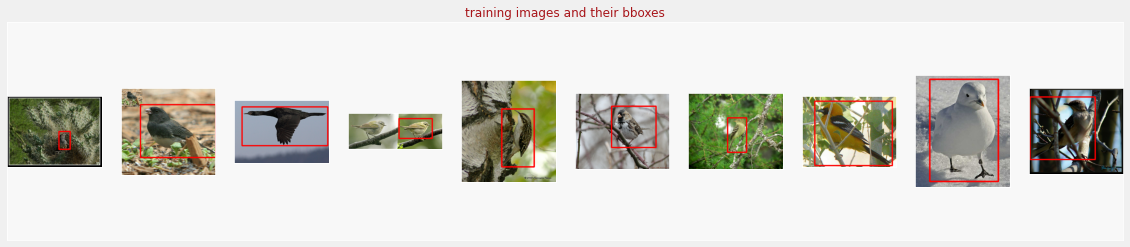

In [10]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

Visualize the validation images and their bounding boxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


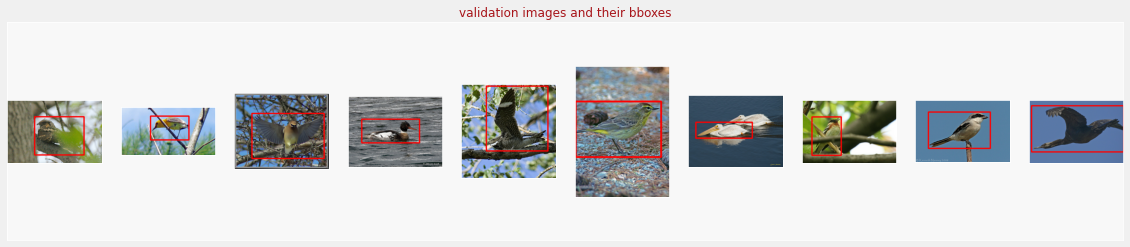

In [11]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

## **2.3 Load and prepare the datasets for the model**
These next two functions read and prepare the datasets that you'll feed to the model.


*   They use read_image_tfds to resize, and normalize each image and its bounding box label.
*   They performs shuffling and batching.
*   You'll use these functions to create training_dataset and validation_dataset, which you will give to the model that you're about to build.





In [12]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

# **3. Define the Network**
Bounding box prediction is treated as a "regression" task, in that you want the model to output numerical values.


*   We will be performing transfer learning with MobileNet V2. The model architecture is available in TensorFlow Keras.
*   We'll also use pretrained 'imagenet' weights as a starting point for further training. These weights are also readily available
*   We will choose to retrain all layers of MobileNet V2 along with the final classification layers.


Parameters:


*   input_shape: (height, width, channel): input images have height and width of 224 by 224, and have red, green and blue channels.
*   include_top: you do not want to keep the "top" fully connected layer, since you will customize your model for the current task.
*   weights: Use the pre-trained 'imagenet' weights.





In [14]:
def feature_extractor(inputs):
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(input_shape= [224,224,3], include_top=False, weights= 'imagenet')

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
        
    # return the feature_extractor
    return feature_extractor

In [15]:
def dense_layers(features):
    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features) 
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x) 
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    
    return x

Defining a layer that outputs the bounding box predictions.
*   We have 4 units in the output layer, corresponding to (xmin, ymin, xmax, ymax).
*   The prediction layer follows the previous dense layer, which is passed into this function as the variable x.


In [16]:
def bounding_box_regression(x): 
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4, name = 'bounding_box')(x) 
    return bounding_box_regression_output

Final model:
*   feature_extractor(inputs)
*   dense_layers(features)
*   bounding_box_regression(x)

In [17]:
def final_model(inputs):
    # features
    feature_cnn = feature_extractor(inputs) 

    # dense layers
    last_dense_layer = dense_layers(feature_cnn) 

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.models.Model(inputs = inputs, outputs = bounding_box_output) 
    
    return model

While defining input layer, set the shape parameter. Check definition of feature_extractor to see the expected dimensions of the input image

In [18]:
def define_and_compile_model():

    # define the input layer
    inputs = tf.keras.layers.Input(shape = (224, 224,3))
    
    # create the model
    model = final_model(inputs) 
    
    # compile your model 
    model.compile(optimizer= tf.keras.optimizers.SGD(momentum=0.9) , loss = 'mse' )    
    
    return model

In [19]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
________________________________________________________________

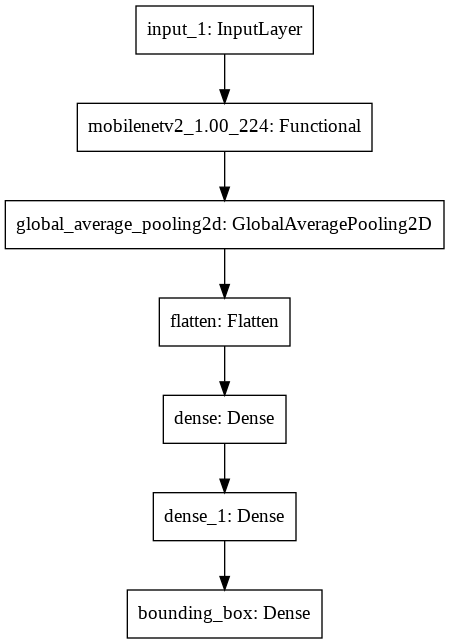

In [20]:
tf.keras.utils.plot_model(model)

# **4. Train the model**
## **4.1 Parameters:**


*   length_of_training_dataset: this is the number of training examples. You can find this value by getting the length of visualization_training_dataset.
Note: You won't be able to get the length of the object training_dataset. (You'll get an error message).
*   length_of_validation_dataset: this is the number of validation examples. You can find this value by getting the length of visualization_validation_dataset.
Note: You won't be able to get the length of the object validation_dataset.
*   steps_per_epoch: This is the number of steps it will take to process all of the training data.If the number of training examples is not evenly divisible by the batch size, there will be one last batch that is not the full batch size.
Try to calculate the number steps it would take to train all the full batches plus one more batch containing the remaining training examples. There are a couples ways you can calculate this.
You can use regular division / and import math to use math.ceil()
Alternatively, you can use // for integer division, % to check for a remainder after integer division, and an if statement.
*   validation_steps: This is the number of steps it will take to process all of the validation data. You can use similar calculations that you did for the step_per_epoch, but for the validation dataset.





In [21]:
# You'll train 50 epochs
EPOCHS = 50

# Choose a batch size
BATCH_SIZE = 64

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset) 
print(length_of_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset) 
print(length_of_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = length_of_training_dataset // BATCH_SIZE 
if length_of_training_dataset % BATCH_SIZE > 0:
    steps_per_epoch += 1 

print(steps_per_epoch)

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
    
print(validation_steps)

3000
3033
47
48


## **4.2 Fit the model to the data**
*   x: this can be a tuple of both the features and labels, as is the case here when using a tf.Data dataset.
Note, don't set the y parameter when the x is already set to both the features and labels.
*   steps_per_epoch: the number of steps to train in order to train on all examples in the training dataset.
*   validation_data: this is a tuple of both the features and labels of the validation set
*   validation_steps: teh number of steps to go through the validation set, batch by batch.




In [22]:
# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(training_dataset , steps_per_epoch= steps_per_epoch, validation_data=validation_dataset, validation_steps = validation_steps, epochs = EPOCHS)


Epoch 1/50
47/47 [==============================] - 87s 1s/step - loss: 0.0942 - val_loss: 0.3344
Epoch 2/50
47/47 [==============================] - 55s 1s/step - loss: 0.0177 - val_loss: 0.2560
Epoch 3/50
47/47 [==============================] - 49s 1s/step - loss: 0.0128 - val_loss: 0.2086
Epoch 4/50
47/47 [==============================] - 55s 1s/step - loss: 0.0102 - val_loss: 0.1718
Epoch 5/50
47/47 [==============================] - 50s 1s/step - loss: 0.0085 - val_loss: 0.1427
Epoch 6/50
47/47 [==============================] - 50s 1s/step - loss: 0.0072 - val_loss: 0.1199
Epoch 7/50
47/47 [==============================] - 50s 1s/step - loss: 0.0066 - val_loss: 0.1026
Epoch 8/50
47/47 [==============================] - 50s 1s/step - loss: 0.0058 - val_loss: 0.0923
Epoch 9/50
47/47 [==============================] - 50s 1s/step - loss: 0.0051 - val_loss: 0.0783
Epoch 10/50
47/47 [==============================] - 49s 1s/step - loss: 0.0048 - val_loss: 0.0713
Epoch 11/50
47/47 [

## **5. Validate the Model**
### **5.1 Loss**

In [23]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

48/48 [==============================] - 14s 284ms/step - loss: 0.0176
Loss:  0.017638040706515312


### **5.2 Save your Model**

In [24]:
# Please save your model
model.save("birds.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### **5.3 Download your model**

In [25]:
# And download it using this shortcut or from the "Files" panel to the left
from google.colab import files

files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **5.4 Plot Loss Function**

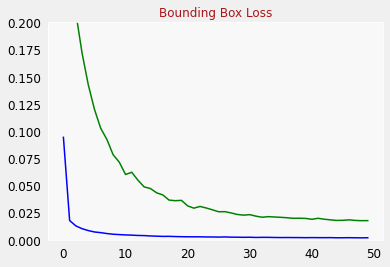

In [26]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

### **5.5 Calculating the Intersection-over-union (IoU) score for each image.**

In [27]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(xmin_pred, xmin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred + 1) * (ymax_pred - ymin_pred + 1)
    true_box_area = (xmax_true - xmin_true + 1) * (ymax_true - ymin_true + 1)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap) + 1,0)  * np.maximum((ymax_overlap - ymin_overlap) + 1, 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    #Updates iou score
    iou = overlap_area / union_area

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.7

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.7): 329
Number of predictions where iou < threshold(0.7): 171


## **6. Visualize Predictions**

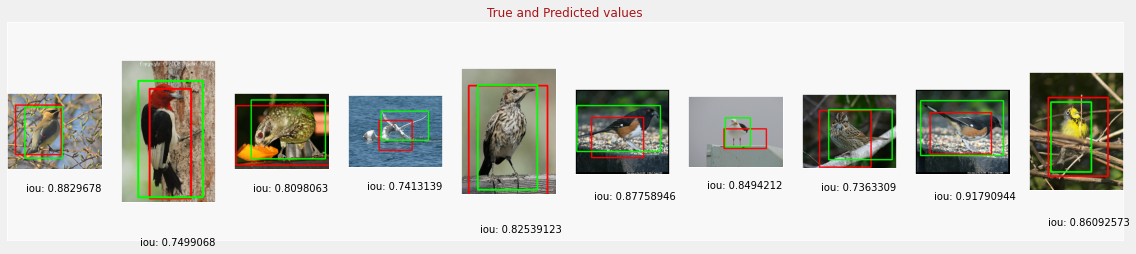

In [28]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)